# 계산그래프를 통해 순전파, 역전파 구현

In [1]:
import numpy as np

# 0. 계산에서 사용하는 곱셈, 덧셈 Layer 정의
각 층마다 이 layer를 깔아 계산그래프를 완성시킴

In [2]:
# 곱셈 Layer(순전파, 역전파)
class MultLayer:
    # 변수 설정
    def __init__(self):
        self.x = None
        self.y = None
    
    # 순전파는 x와 y를 곱하기
    def forward(self, x, y):
        self.x = x
        self.y = y

        return x * y

    # 곱셈 노드의 역전파는 미분값에다가 교차시켜서 곱하는 방식
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy

# 덧셈 Layer(순전파, 역전파)
class AddLayer:
    def forward(self, x, y):
        return x + y

    # 덧셈 노드의 역전파는 하류의 값을 그대로 올려보냄
    def backward(self, dout):
        return dout, dout

# 1. 사과 가격 구하기
### 곱셈 Layer로만 그려진 계산 그래프
사과 * 개수 * 세금

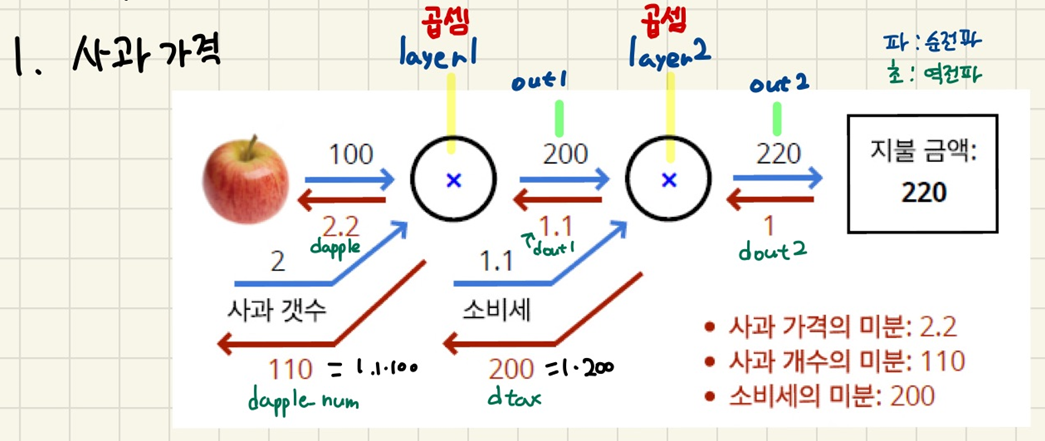

In [3]:
# 사과, 개수, 세금 정의
apple = 100
apple_num = 2
tax = 1.1

# 곱셈 layer 불러오기
layer1 = MultLayer()
layer2 = MultLayer()

# 순전파
out1 = layer1.forward(apple, apple_num)
out2 = layer2.forward(out1, tax)

print('순전파: 사과->지불금액')
print('price =', out2 )

print('*'*30)
print('역전파: 지불금액->사과')
# 역전파 layer 정의

dout2 = 1
dout1, dtax = layer2.backward(dout2)
dapple, dapple_num = layer1.backward(dout1)

print('dout1 =', dout1)
print('dtax =', dtax)
print('dapple =', dapple)
print('dapple_num =', dapple_num)

순전파: 사과->지불금액
price = 220.00000000000003
******************************
역전파: 지불금액->사과
dout1 = 1.1
dtax = 200
dapple = 2.2
dapple_num = 110.00000000000001


# 2. 사과, 오렌지 가격 구하기
### 곱셈, 덧셈으로 이루어진 Layer

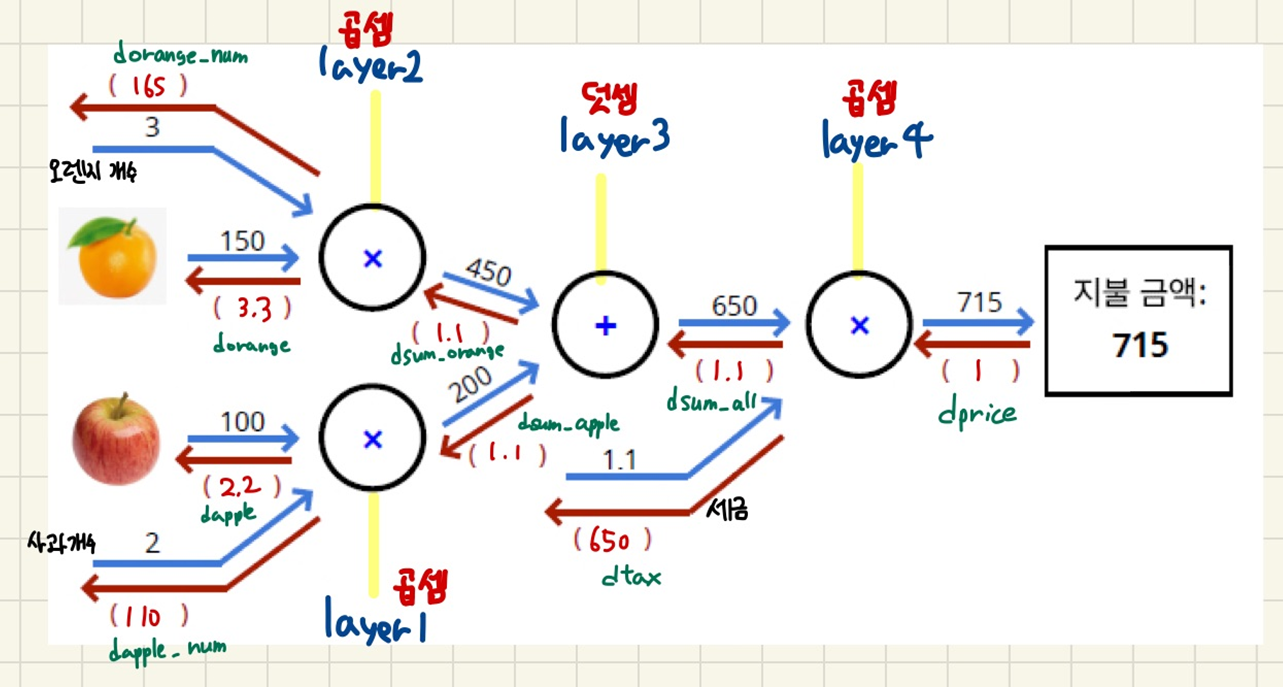

In [4]:
# 사과, 사과 개수, 오렌지, 오렌지 개수, 세금 정의
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# Layer 설정, 곱셈과 덧셈
layer1 = MultLayer()
layer2 = MultLayer()
layer3 = AddLayer()
layer4 = MultLayer()

# 순전파
sum_apple = layer1.forward( apple, apple_num )
sum_orange = layer2.forward( orange, orange_num )
# layer3 는 sum_apple, sum_orange
sum_all = layer3.forward( sum_apple, sum_orange )
price = layer4.forward( sum_all, tax )

# backward
dprice = 1
dsum_all, dtax = layer4.backward( dprice )
dsum_apple, dsum_orange = layer3.backward( dsum_all )
dorange, dorange_num = layer2.backward( dsum_orange )
dapple, dapple_num = layer1.backward( dsum_apple )

print('price = {:.2f}'.format(price))
print('dapple = {:.2f}, dapple_num = {:.2f}, \
dorange = {:.2f}, dorange_num = {:.2f}, \
dtax = {:.2f}'.format(dapple, dapple_num, dorange, dorange_num, dtax))

price = 715.00
dapple = 2.20, dapple_num = 110.00, dorange = 3.30, dorange_num = 165.00, dtax = 650.00


# 3. 활성화 함수 -ReLU, Sigmoid

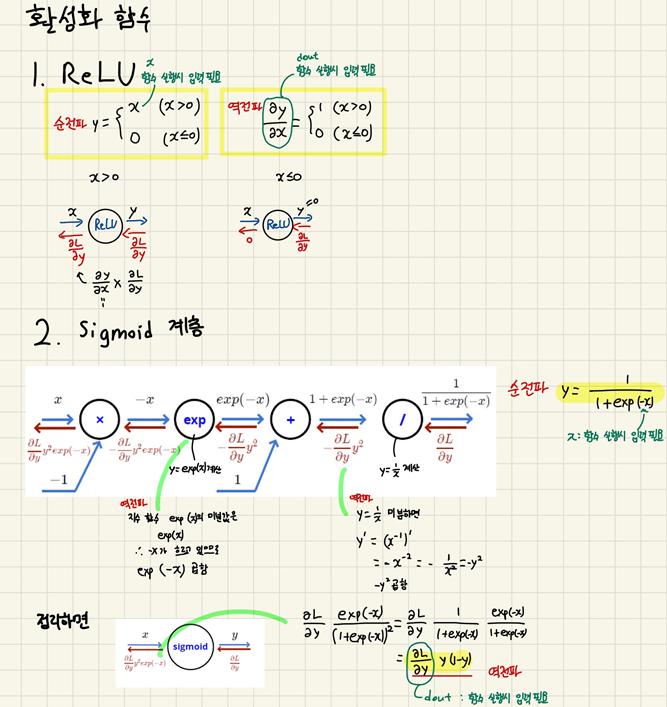

In [5]:
class ReLU:
    def __init__(self):
        self.mask = None

# x는 입력 array
# x가 0 이하인 값을 mask로 저장(bool)
    def forward(self, x):
        self.mask = (x <= 0)
        # 위 마스크는 0이하인 값이 True
        out = x.copy()
        out[self.mask] = 0
        # 0이하인 값을 0으로 0초과를 x로 내버려두기
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        # 0이하인 값의 미분값을 0으로 바꾸기
        dx = dout
        # 0초과는 그대로 전파
        
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

# 4. 어파인 계층

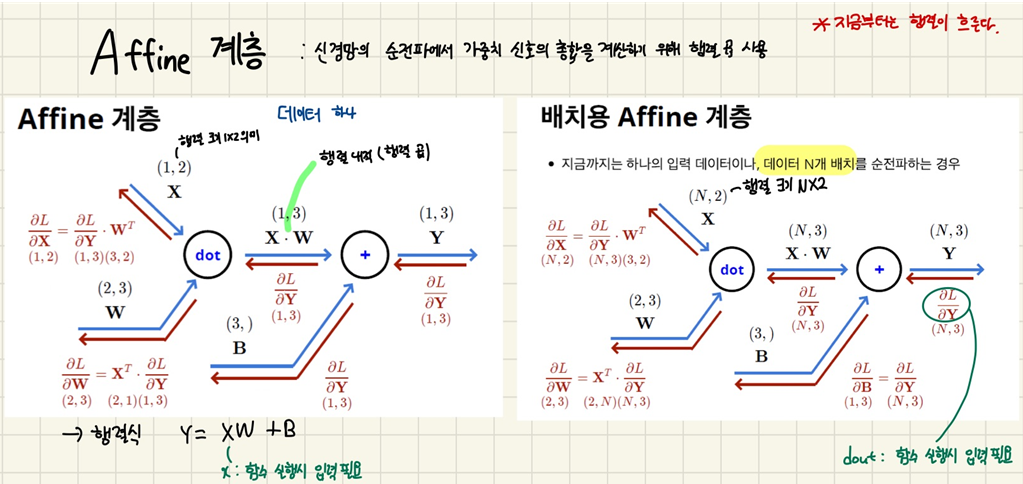

In [6]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

# 5. Softmax-with-Loss 계층

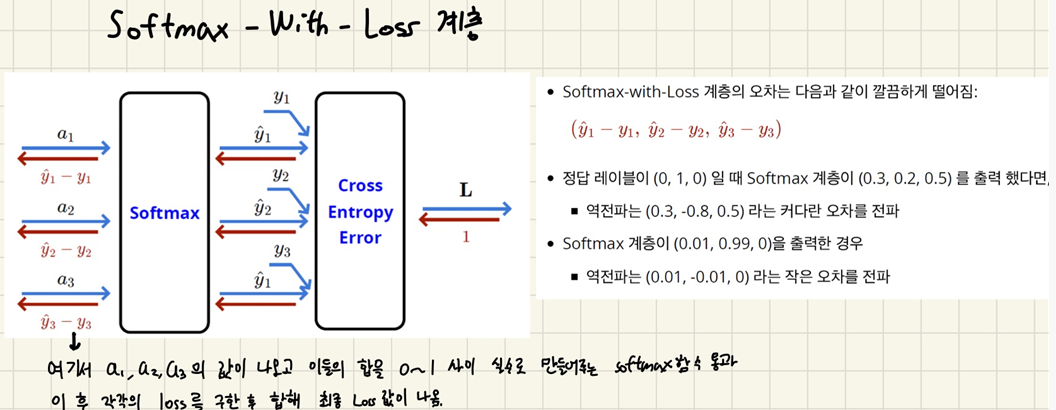

In [7]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.o = None
        self.t = None
        
    def forward(self, x, t):
        # 이전에 정의한 softmax를 중첩함수로 집어넣기
        def softmax(a):
            if a.ndim >= 2:
                c = np.max( a, axis=1, keepdims=True )
                exp_a = np.exp(a - c)
                sum_exp_a = np.sum( exp_a, axis=1, keepdims=True )
            else:
                c = np.max(a)
                exp_a = np.exp(a - c)
                sum_exp_a = np.sum(exp_a)

            return exp_a / sum_exp_a
        
        # t는 정답 레이블
        # x는 입력값
        # o는 x를 소프트맥스에 집어넣어서 나오는 값
        self.t = t
        self.o = softmax(x)
        self.loss = ce_loss(self.o, self.t)
    
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        # 정답 레이블인 t의 원소개수를 batch_size로 두기
        dx = (self.o - self.t) / batch_size
        # 데이터 하나당의 기울기를 전파하기 위해 batch_size로 나누기
        
        return dx

# 6. 오차역전파법 손글씨로 실습 진행

In [8]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

X = X.values.astype(np.float) / 255.
y = y.values.astype(np.uint8)

# one-hot encoding
y = np.eye(10)[y]

x_train = X[:60000]
x_test = X[60000:]
t_train = y[:60000]
t_test = y[60000:]

print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

C:\Users\cdlee\AppData\Local\Temp/ipykernel_19972/2925808917.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = X.values.astype(np.float) / 255.


(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [9]:
# 출력층 소프트맥스 정의
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

# Loss 함수 크로스엔트로피 정의
def ce_loss(o, t):
    if o.ndim == 1:
        t = t.reshape(1, t.size)
        o = o.reshape(1, o.size)
        
    if t.size == o.size:
        t = t.argmax(axis=1)
             
    batch_size = o.shape[0]
    return -np.sum(np.log(o[np.arange(batch_size), t] + 1e-7)) / batch_size

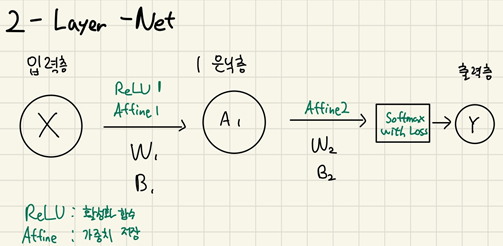

In [10]:
# TwoLayerNet

class TwoLayerNet:
    def __init__(self, i_size, h_size, o_size, init_std = 0.01):
        self.params = {}
        self.params['W1'] = init_std * np.random.randn(i_size, h_size)
        self.params['b1'] = np.zeros(h_size)
        self.params['W2'] = init_std * np.random.randn(h_size, o_size) 
        self.params['b2'] = np.zeros(o_size)
        
        # 3, 4, 5에 정의한 class에서 layer을 가져오는 것
        self.layers = {}
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['SoftmaxWithLoss'] = SoftmaxWithLoss()
        
    def predict(self, x):
        # 3, 4, 5에 정의한 class에서 layer을 가져오는 것
        for key in ('Affine1', 'Relu1', 'Affine2'):
            x = self.layers[key].forward(x)
        
        return x
        
    def loss(self, x, t):
        # o는 y_hat 값
        o = self.predict(x)
        return self.layers['SoftmaxWithLoss'].forward(o, t)
    
    def accuracy(self, x, t):
        o = self.predict(x)
        o = np.argmax(o, axis=1)
        if t.ndim != 1: 
            t = np.argmax(t, axis=1)
        
        # 일치하는 개수를 전체 배치 사이즈만큼 나눠주기
        accuracy = np.sum(o == t) / float(x.shape[0])
        return accuracy
    
    # affine 계층을 이용해 gradient 저장해두기
    # gradient를 저장해두어야만 역전파 계산할 수 있음
    def gradient(self, x, t):
        
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        for key in ('SoftmaxWithLoss', 'Affine2', 'Relu1', 'Affine1'):
            dout = self.layers[key].backward(dout)

        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

In [11]:
# 학습시작
network = TwoLayerNet(i_size=784, h_size=100, o_size=10)

train_size = x_train.shape[0]
batch_size = 100

learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size // batch_size, 1)
epoch_num = 50
iters_num = epoch_num * iter_per_epoch

epoch = 0

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch)

    for key in network.params.keys():
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch += 1
        print( 'epoch {} accuracy: train {:.4f}, test {:.4f}'.format(
            epoch, train_acc, test_acc) )


epoch 1 accuracy: train 0.1721, test 0.1687
epoch 2 accuracy: train 0.9043, test 0.9108
epoch 3 accuracy: train 0.9292, test 0.9302
epoch 4 accuracy: train 0.9398, test 0.9388
epoch 5 accuracy: train 0.9510, test 0.9484
epoch 6 accuracy: train 0.9568, test 0.9530
epoch 7 accuracy: train 0.9607, test 0.9563
epoch 8 accuracy: train 0.9651, test 0.9591
epoch 9 accuracy: train 0.9688, test 0.9633
epoch 10 accuracy: train 0.9717, test 0.9642
epoch 11 accuracy: train 0.9741, test 0.9667
epoch 12 accuracy: train 0.9756, test 0.9685
epoch 13 accuracy: train 0.9780, test 0.9694
epoch 14 accuracy: train 0.9802, test 0.9715
epoch 15 accuracy: train 0.9806, test 0.9712
epoch 16 accuracy: train 0.9827, test 0.9733
epoch 17 accuracy: train 0.9826, test 0.9737
epoch 18 accuracy: train 0.9842, test 0.9742
epoch 19 accuracy: train 0.9859, test 0.9744
epoch 20 accuracy: train 0.9862, test 0.9739
epoch 21 accuracy: train 0.9872, test 0.9745
epoch 22 accuracy: train 0.9878, test 0.9750
epoch 23 accuracy: 

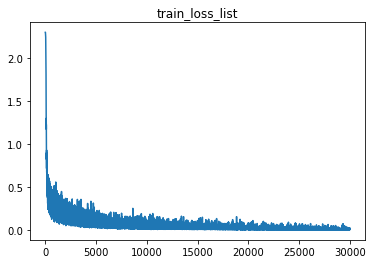

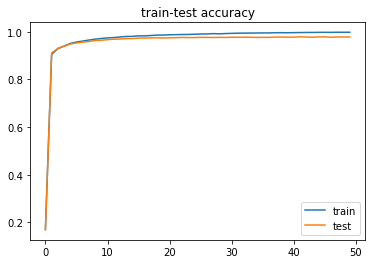

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list)
plt.title("train_loss_list")
plt.show()

plt.plot(train_acc_list, label='train')
plt.plot(test_acc_list, label='test')
plt.legend()
plt.title("train-test accuracy")
plt.show()

In [18]:
# ThreeLayerNet

class ThreeLayerNet:

    def __init__(self, i_size, h1_size, h2_size, o_size, init_std = 0.01):

        self.params = {}
        self.params['W1'] = init_std * np.random.randn(i_size, h1_size)
        self.params['b1'] = np.zeros(h1_size)
        self.params['W2'] = init_std * np.random.randn(h1_size, h2_size) 
        self.params['b2'] = np.zeros(h2_size)
        self.params['W3'] = init_std * np.random.randn(h2_size, o_size) 
        self.params['b3'] = np.zeros(o_size)

        self.layers = {}
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = ReLU()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['SoftmaxWithLoss'] = SoftmaxWithLoss()


    def predict(self, x): 
        for key in ('Affine1', 'Relu1', 'Affine2', 'Relu2', 'Affine3'):
            x = self.layers[key].forward(x)
        
        return x
        
    def loss(self, x, t):
        o = self.predict(x)
        return self.layers['SoftmaxWithLoss'].forward(o, t)
    
    def accuracy(self, x, t):
        o = self.predict(x)
        o = np.argmax(o, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(o == t) / float(x.shape[0])
        return accuracy
        
    def gradient(self, x, t):
        
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        for key in ('SoftmaxWithLoss', 'Affine3' , 'Relu2', 'Affine2', 'Relu1', 'Affine1'):
            dout = self.layers[key].backward(dout)

        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        grads['W3'] = self.layers['Affine3'].dW
        grads['b3'] = self.layers['Affine3'].db
        
        return grads

In [19]:
network = ThreeLayerNet(i_size=784, h1_size=300, h2_size=50, o_size=10)

train_size = x_train.shape[0]
batch_size = 100

learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size // batch_size, 1)
epoch_num = 50
iters_num = epoch_num * iter_per_epoch

epoch = 0

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch)
    
    for key in network.params.keys():
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch += 1
        print( 'epoch {} accuracy: train {:.4f}, test {:.4f}'.format(epoch, train_acc, test_acc) )

epoch 1 accuracy: train 0.1044, test 0.1028
epoch 2 accuracy: train 0.8473, test 0.8481
epoch 3 accuracy: train 0.9167, test 0.9154
epoch 4 accuracy: train 0.9440, test 0.9423
epoch 5 accuracy: train 0.9567, test 0.9525
epoch 6 accuracy: train 0.9654, test 0.9594
epoch 7 accuracy: train 0.9741, test 0.9670
epoch 8 accuracy: train 0.9761, test 0.9702
epoch 9 accuracy: train 0.9823, test 0.9727
epoch 10 accuracy: train 0.9841, test 0.9738
epoch 11 accuracy: train 0.9865, test 0.9754
epoch 12 accuracy: train 0.9882, test 0.9762
epoch 13 accuracy: train 0.9883, test 0.9737
epoch 14 accuracy: train 0.9915, test 0.9773
epoch 15 accuracy: train 0.9919, test 0.9775
epoch 16 accuracy: train 0.9936, test 0.9773
epoch 17 accuracy: train 0.9940, test 0.9794
epoch 18 accuracy: train 0.9950, test 0.9789
epoch 19 accuracy: train 0.9959, test 0.9795
epoch 20 accuracy: train 0.9967, test 0.9804
epoch 21 accuracy: train 0.9975, test 0.9805
epoch 22 accuracy: train 0.9946, test 0.9789
epoch 23 accuracy: 

test

Failed images # 204


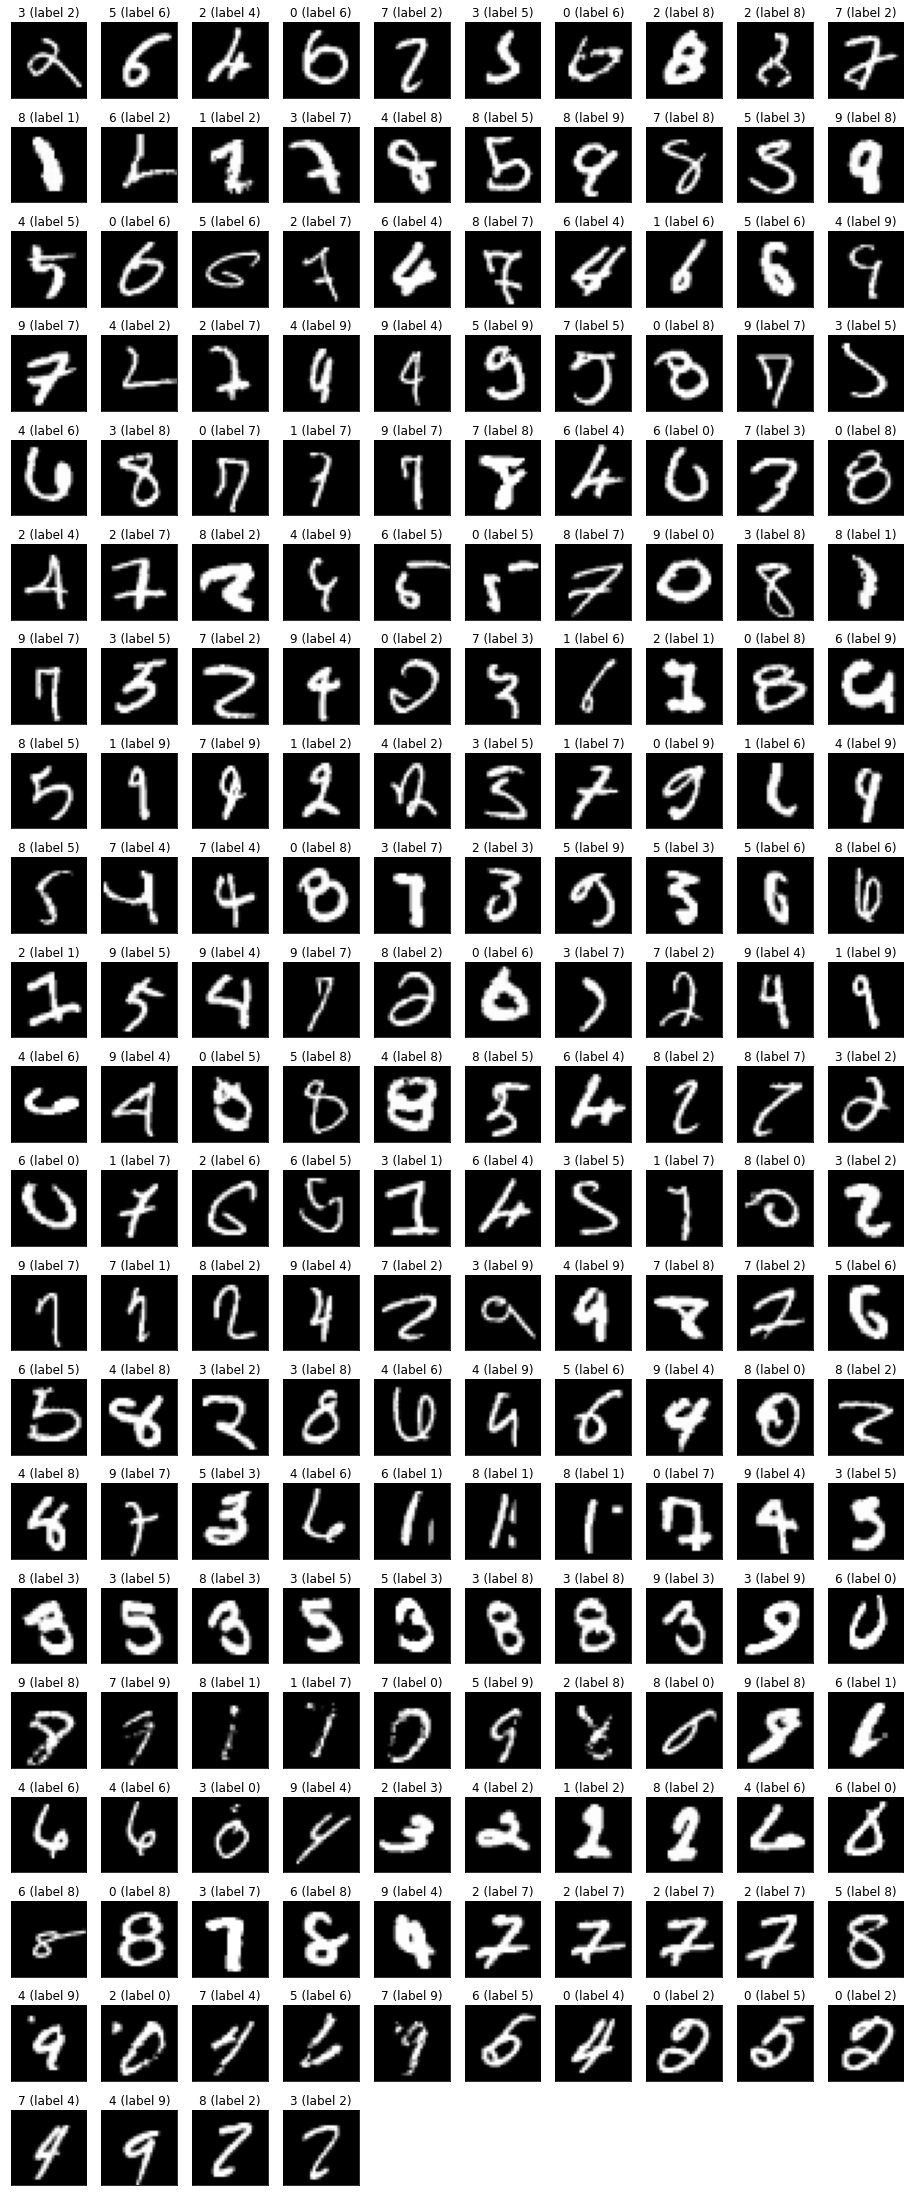

In [20]:
o_test = network.predict(x_test)

o1_test = np.argmax(o_test, axis=1)
t1_test = np.argmax(t_test, axis=1)

fail_mask = o1_test != t1_test

fail_images = x_test[ fail_mask ]
fail_predicts = o1_test[ fail_mask ]
fail_labels = t1_test[ fail_mask ]

fig = plt.figure(figsize=(16, 40))

image_num = fail_images.shape[0]
print('Failed images #', image_num)

for i in range(image_num):
    ax = fig.add_subplot( (image_num // 10) + 1, 10, i+1 )
    ax.set_title( '{} (label {})'.format(fail_predicts[i], fail_labels[i]) )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow( fail_images[i].reshape(28, 28), cmap='gray' )
plt.show()